# Molecular evolution modeling
*Matthew Wakefield*

In this tutorial we are going to construct and assess a model of molecular evolution on a tree. To simplify the analysis we will use a specific simple tree shown below. 


```
         Sequence1            Sequence2
             \                   /
              \                 /
               \               /
 length = t1    \             / length = t2
                 \           /
                  \         /
                   \       /
                   Ancestral
```

This tree is used as it has the fundamental features that would be iterated over when implementing a pruning algorithm.

In [47]:
sequence1 = 'GATCGATCGATCGATCGATCGATCGATCGATCGATCGATC'
sequence2 = 'GATCGATCGATCGATCGATCGATCGATCGATCGATCGATC'

We are going to construct a Q matrix for the modeling. We do this using numpy, the numerical library for python, and use the array data structure.  This is by default floats.
As we will not be varying the mutation rate we dont need to keep remaking this matrix and it will be a constant in our calculations. Similarly because the JC69 assumes motif probabilities are constant and equal we dont need to worry about varying them either. 

In [27]:
import numpy

In [34]:
mu=1
jc69Q = numpy.array([[-3.0*mu/4.0,     mu/4.0,     mu/4.0,     mu/4.0],
                     [     mu/4.0,-3.0*mu/4.0,     mu/4.0,     mu/4.0],
                     [     mu/4.0,     mu/4.0,-3.0*mu/4.0,     mu/4.0],
                     [     mu/4.0,     mu/4.0,     mu/4.0,-3.0*mu/4.0],
                    ])

In [35]:
jc69Q

array([[-0.75,  0.25,  0.25,  0.25],
       [ 0.25, -0.75,  0.25,  0.25],
       [ 0.25,  0.25, -0.75,  0.25],
       [ 0.25,  0.25,  0.25, -0.75]])

We will be multiplying the Q matrix by time (t) which is a scalar.

In [37]:
jc69Q*3

array([[-2.25,  0.75,  0.75,  0.75],
       [ 0.75, -2.25,  0.75,  0.75],
       [ 0.75,  0.75, -2.25,  0.75],
       [ 0.75,  0.75,  0.75, -2.25]])

When calculating the probability we will need to get a single column of the matrix as this will be the ancestral node probabilities. To make this easy we can create a dictionary corresponding to the matrix index.

In [40]:
jc69Q[0]

array([-0.75,  0.25,  0.25,  0.25])

In [41]:
base_index = {'A':0,'G':1,'C':2,'T':3,}

In [42]:
jc69Q[base_index['A']]

array([-0.75,  0.25,  0.25,  0.25])

In [53]:
#you wont need this but you can do multi dimensional lookups as well
jc69Q[base_index['A']][base_index['A']]

-0.75

To calculate the probability across our tree we need to calculate five probabilities, the probability at each of the three nodes and the transition probability at each of the two branches.
First we will calculate the probabilities of the tip nodes.

## Exercise 1
Calculate the probability of each of the two tip nodes.

*hints:*

*under this model they are both the same*

you will need numpy.log() and the ** operator

In [52]:
pr_seq1 = numpy.log(0.25)**len(sequence1)
pr_seq2 = numpy.log(0.25)**len(sequence1)

We now need to calculate the transition probability from each of the nodes.  We are going to simplify this and constrain both the branch lengths to be equal so we only need to make one probability matrix.

We need to calculate the product of tQ and the exponential of the resulting matrix. To calculate the exponential we will use the scipy.linalg.expm() function that uses the Pad√© approximation.

In [57]:
from scipy.linalg import expm

In [63]:
def make_transition_matrix(t, Q):
    return expm(t*Q)

Next we need to apply the probability matrix across the sequence. To do this we will need a function that calculates the transition probability matrix, and then process the probabilities for each site in the sequence.

We will have two probabilites at the ancestral site, the probability of the length to sequence1 and the probability of the length to sequence2.
As we are interested in the probability for both data points we will multiply these probabilities to get the combined probability of sequence1 and sequence2 at that site.

At each site multiple probabilities will be generated, and as these represent alternative probabilites we sum them together.


In [77]:
def get_site_probability(motif1, motif2, t1, t2, Q=jc69Q):
    base_index = {'A':0,'G':1,'C':2,'T':3,}
    P1 = make_transition_matrix(t1,Q)
    P2 = make_transition_matrix(t2,Q)
    return sum(P1[base_index[motif1]]*P2[base_index[motif2]])

In [78]:
get_site_probability('A','A',1,1)

0.35150146242745944

To get the likelihood of the sequence we need to iterate over each site in the sequence, take the log and accumulate the sum of the logs.

In [83]:
def get_sequence_loglikelihood(seq1, seq2,
                               t1, t2,
                               Q=jc69Q):
    likelihood = 0
    assert len(seq1)==len(seq2)
    for i in range(len(seq1)):
        likelihood += numpy.log(
            get_site_probability(seq1[i],seq2[i],
                                 t1,t2,Q))
    return likelihood

In [86]:
#This is a special case, identical sequences and zero branch length
get_sequence_loglikelihood('AAAA','AAAA',0,0)

0.0

In [88]:
get_sequence_loglikelihood('AAAA','AATA',0.1,0.1)

-3.5324468055704896

In [89]:
get_sequence_loglikelihood('AAAA','ACTA',0.1,0.1)

-6.480386086500874

The above code works as expected, however we end up doing lots of calls to the expensive expm function.

## Optional exercise
Refactor the functions to reduce the number of calls to expm

## Exercise 2
Try some different sequences. Does it matter what the base changes are? If you have the same proportion of changes do you get the same results? Same proportion of conserved sites? What happens as the sequence gets longer? Does swapping t1 and t2 give the same likelihood result?


## Exercise 3
Plot the likelihood against t using a single value of t for both branch lengths. Do this for identical sequences and sequences with 25% difference.

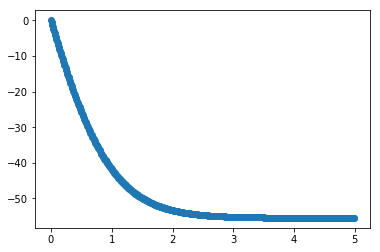

In [101]:
import matplotlib

lnLs = []
ts = []

for t in range(0,500):
    t= t/100.0
    ts.append(t)
    lnLs.append(get_sequence_loglikelihood(sequence1,
                                           sequence2,
                                           t,t))

matplotlib.pyplot.scatter(x=ts,y=lnLs)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


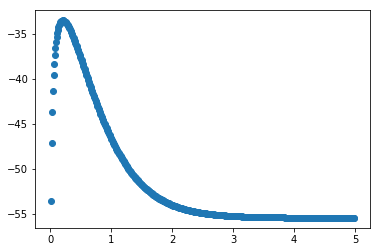

In [102]:
lnLs = []
ts = []

sequence3 = sequence2.replace('C','T')

for t in range(0,500):
    t= t/100.0
    ts.append(t)
    lnLs.append(get_sequence_loglikelihood(sequence1,
                                           sequence3,
                                           t,t))

matplotlib.pyplot.scatter(x=ts,y=lnLs)

